# Fine-Tuning + Inference API 

## 1. Подготовка данных. Для обучения использован поднабор RVL-CDIP (тестовая часть), так как официальный train set недоступен. Разделение выполнено стратифицированно

### Создание датасета для тренировки

In [25]:
import os
import shutil

In [21]:
classes = ['invoice', 'letter', 'email', 'news_article']
number_of_files = 2000

In [ ]:
# os.chdir('data')
# os.mkdir('train')

In [3]:
train_path = os.path.join('data', 'train')
test_path = os.path.join('data', 'test')

In [ ]:
# os.chdir(os.path.join('..', '..'))
# os.getcwd()

'/home/ilgiz/ml-engineering-portfolio/doc_image_classification'

In [ ]:
# os.chdir(dest_path)
# for i in range(len(classes)):
#     os.mkdir(classes[i])

# os.chdir(os.path.join('..', '..'))

In [ ]:
# os.chdir(os.path.join('..', '..'))
# print(os.getcwd())

/home/ilgiz/ml-engineering-portfolio/doc_image_classification


In [38]:
# os.listdir(os.path.join(src_path, classes[0]))[0]
os.getcwd()

'/home/ilgiz/ml-engineering-portfolio/doc_image_classification'

In [ ]:
os.path.join(train_path, classes[0])

In [ ]:
# file = os.listdir(os.path.join(test_path, classes[0]))[0]
# shutil.copy(os.path.join(test_path, classes[0], file), os.path.join(train_path, classes[0]))

'data/train/invoice/ti16311152.tif'

In [ ]:
# for c in classes:
#     for n in range(number_of_files):
#         file = os.listdir(os.path.join(src_path, c))[n]
#         shutil.copy(os.path.join(src_path, c, file), os.path.join(dest_path, c))

In [ ]:
for c in classes:
    print(f'Class: {c} | amount of objects: {len(os.listdir(os.path.join(train_path, c)))}')

Class: invoice | amount of objects: 2000
Class: letter | amount of objects: 2000
Class: email | amount of objects: 2000
Class: news_article | amount of objects: 2000


In [ ]:
os.listdir(os.path.join(test_path, classes[0]))[0]

'ti16311152.tif'

### Создание `transform` и своего класса `Dataset`

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from torchvision.transforms import v2

In [13]:
transform_train = v2.Compose([
    v2.ToImage(),    # Конвертируем PIL -> image
    v2.ToDtype(torch.float32, scale=True),   # Масштабируем [0, 255] -> [0, 1]
    v2.Resize((224, 224), antialias=True), 
    v2.RandomAffine(degrees=3, translate=(.05, .05), scale=(.95, 1.05)),    # лёгкий поворот + сдвиг + масштаб
    v2.GaussianNoise(mean=.0, sigma=.01),
    v2.Normalize([.5, .5, .5], [.5, .5, .5])
])

transform_val = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((224, 224), antialias=True),
    v2.Normalize([.5, .5, .5], [.5, .5, .5])
])

In [6]:
class doc_ds(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        img = Image.open(self.image_paths[index]).convert('RGB')
        if self.transform: img = self.transform(img)
        label = torch.tensor(self.labels[index], dtype=torch.long)
        
        return img, label

In [7]:
df_docs = pd.DataFrame()

In [8]:
df_t1 = pd.DataFrame(columns=['doc_path', 'label'])
df_t2 = pd.DataFrame(columns=df_t1.columns)

In [9]:
classes

['invoice', 'letter', 'email', 'news_article']

In [10]:
class_rpath = os.path.relpath(os.path.join(train_path, classes[0]))
class_rpath

'data/train/invoice'

### Загрузка файлов и разделение на `train`, `validation`, `test`

In [11]:
tvt_files_df = pd.DataFrame(columns=['path', 'labels'])
for c in classes:
    class_rpath = os.path.relpath(os.path.join(train_path, c))
    temp_df = pd.DataFrame(columns=['path', 'labels'])
    temp_df['path'] = class_rpath + '/' + pd.Series(os.listdir(os.path.join(train_path, c)))
    temp_df['labels'] = c
    
    tvt_files_df = pd.concat((tvt_files_df, temp_df), axis=0, ignore_index=True)

tvt_files_df

# tvt_files_df # train, validate, test - data
# tvt_files_df


# invoice_files = pd.Series(os.listdir(os.path.join(train_path, classes[0])))
# letter_files = pd.Series(os.listdir(os.path.join(train_path, classes[1])))

# pd.concat((invoice_files, letter_files), ignore_index=True)

,path,labels
0,data/train/invoice/ti16311152.tif,invoice
1,data/train/invoice/2084022630.tif,invoice
2,data/train/invoice/2063235294.tif,invoice
3,data/train/invoice/83545557.tif,invoice
4,data/train/invoice/2029370755.tif,invoice
...,...,...
7995,data/train/news_article/tob14401.20.tif,news_article
7996,data/train/news_article/1003289799.tif,news_article
7997,data/train/news_article/2048367429.tif,news_article
7998,data/train/news_article/1002402701a.tif,news_article


In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [13]:
tvt_files_df['label_id'] = le.fit_transform(tvt_files_df['labels'])
tvt_files_df

,path,labels,label_id
0,data/train/invoice/ti16311152.tif,invoice,1
1,data/train/invoice/2084022630.tif,invoice,1
2,data/train/invoice/2063235294.tif,invoice,1
3,data/train/invoice/83545557.tif,invoice,1
4,data/train/invoice/2029370755.tif,invoice,1
...,...,...,...
7995,data/train/news_article/tob14401.20.tif,news_article,3
7996,data/train/news_article/1003289799.tif,news_article,3
7997,data/train/news_article/2048367429.tif,news_article,3
7998,data/train/news_article/1002402701a.tif,news_article,3


In [81]:
tvt_files_df[['labels', 'label_id']].drop_duplicates()

,labels,label_id
0,invoice,1
2000,letter,2
4000,email,0
6000,news_article,3


In [ ]:
tvt_files_df['label_id'].unique()

array([1, 2, 0, 3])

In [15]:
from torch.utils.data import random_split

In [16]:
full_doc_ds = doc_ds(tvt_files_df.path.to_list(), tvt_files_df.label_id.to_list(), transform=transform_train)

In [17]:
train_ds, val_ds, test_ds = random_split(full_doc_ds, [.7, .15, .15])

In [18]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

## fine-tuning модели

### Загрузка модели, заморозка слоев, добавление поледнего линейного слоя

In [19]:
import timm
import torch.nn as nn

/home/ilgiz/.cache/pypoetry/virtualenvs/ml-engineering-portfolio-PXL5yKuT-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
# Обображаем параметры модели
def show_model_info(model):
    for k, v in model.default_cfg.items():
        print(f'{k}: {v}')

In [ ]:
model = timm.create_model('efficientnet_b0', pretrained=True)


for param in model.parameters():    # Замораживаем слои
    param.requires_grad = False

model.classifier = nn.Linear(model.classifier.in_features, 4)     # Добавляем новый полносвязный слой с активными градиентами


show_model_info(model)

url: https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth
hf_hub_id: timm/efficientnet_b0.ra_in1k
architecture: efficientnet_b0
tag: ra_in1k
custom_load: False
input_size: (3, 224, 224)
fixed_input_size: False
interpolation: bicubic
crop_pct: 0.875
crop_mode: center
mean: (0.485, 0.456, 0.406)
std: (0.229, 0.224, 0.225)
num_classes: 1000
pool_size: (7, 7)
first_conv: conv_stem
classifier: classifier
license: apache-2.0


In [119]:
print([p.requires_grad for p in model.parameters()][-5:])  # последние 5 тензоров — должны быть True (голова)

[False, False, False, True, True]


### Обучение головы модели

In [132]:
epochs = 6
learning_rate = 1e-3    # 1e-3 - 3e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [131]:
model = model.to(device)

In [21]:
def train_model(model, loader, optimizer, criterion):
    total_loss, correct_preds = 0, 0
    for imgs, targets in loader:
        imgs = imgs.to(device); targets = targets.to(device)
        
        optimizer.zero_grad()
        
        preds = model(imgs)
        loss = criterion(preds, targets)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * imgs.size(0)
        correct_preds += (preds.argmax(dim=1) == targets).sum().item()
        
    return total_loss / len(loader.dataset), correct_preds / len(loader.dataset)            

In [22]:
def evaluate_model(model, loader, criterion):
    total_loss, correct_preds = 0, 0
    torch.inference_mode()
    for imgs, targets in loader:
        imgs = imgs.to(device); targets = targets.to(device)
        
        preds = model(imgs)
        loss = criterion(preds, targets)
        
        total_loss += loss.item() * imgs.size(0)
        correct_preds += (preds.argmax(dim=1) == targets).sum().item()  
        
    
    return total_loss / len(loader.dataset), correct_preds / len(loader.dataset)   

In [23]:
from tqdm import tqdm    # Полоска загрузки

In [161]:
total_train_acc, total_val_acc = [], []
total_train_loss, total_val_loss = [], []

for e in range(epochs):
    train_loss, train_acc = train_model(model, train_dl, optimizer, criterion)
    val_loss, val_acc = evaluate_model(model, val_dl, criterion)
    
    total_train_acc.append(train_acc); total_train_loss.append(train_loss)
    total_val_acc.append(val_acc); total_val_loss.append(val_acc)
    
    print(f"Epoch: {e+1}/{epochs} | Train accuracy: {train_acc:.4f}%, Train loss: {train_loss:.4f} | Validation accuracy: {val_acc:.4f}%, Validation loss: {val_loss:.4f}")

Epoch: 1/6 | Train accuracy: 0.8154%, Train loss: 0.5162 | Validation accuracy: 0.8008%, Validation loss: 0.5263
Epoch: 2/6 | Train accuracy: 0.8325%, Train loss: 0.4786 | Validation accuracy: 0.8117%, Validation loss: 0.5056
Epoch: 3/6 | Train accuracy: 0.8370%, Train loss: 0.4698 | Validation accuracy: 0.8158%, Validation loss: 0.4968
Epoch: 4/6 | Train accuracy: 0.8387%, Train loss: 0.4540 | Validation accuracy: 0.8183%, Validation loss: 0.4896
Epoch: 5/6 | Train accuracy: 0.8389%, Train loss: 0.4452 | Validation accuracy: 0.8267%, Validation loss: 0.4753
Epoch: 6/6 | Train accuracy: 0.8379%, Train loss: 0.4474 | Validation accuracy: 0.8292%, Validation loss: 0.4725


In [ ]:
# torch.save(model.state_dict(), 'models/efficientnet_b0_doc_classifier_head_only.pth')

### Обучение всей модели с 4 выходами

In [28]:
model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=4)
model.load_state_dict(torch.load('models/efficientnet_b0_doc_classifier_head_only.pth', weights_only=True))
model.to(device)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [29]:
for param in model.parameters():
    param.requires_grad = True

In [30]:
epochs = 10
learning_rate = 1e-5     # 1e-5 - 5e-5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

### Дообучение

In [31]:
total_train_acc, total_val_acc = [], []
total_train_loss, total_val_loss = [], []

for e in range(epochs):
    train_loss, train_acc = train_model(model, train_dl, optimizer, criterion)
    val_loss, val_acc = evaluate_model(model, val_dl, criterion)
    
    total_train_acc.append(train_acc); total_train_loss.append(train_loss)
    total_val_acc.append(val_acc); total_val_loss.append(val_acc)
    
    print(f"Epoch: {e+1}/{epochs} | Train accuracy: {train_acc:.4f}%, Train loss: {train_loss:.4f} | Validation accuracy: {val_acc:.4f}%, Validation loss: {val_loss:.4f}")

Epoch: 1/10 | Train accuracy: 0.8514%, Train loss: 0.4154 | Validation accuracy: 0.8650%, Validation loss: 0.3802
Epoch: 2/10 | Train accuracy: 0.8686%, Train loss: 0.3736 | Validation accuracy: 0.8717%, Validation loss: 0.3765
Epoch: 3/10 | Train accuracy: 0.8755%, Train loss: 0.3455 | Validation accuracy: 0.8550%, Validation loss: 0.3933
Epoch: 4/10 | Train accuracy: 0.8768%, Train loss: 0.3436 | Validation accuracy: 0.8825%, Validation loss: 0.3452
Epoch: 5/10 | Train accuracy: 0.8859%, Train loss: 0.3168 | Validation accuracy: 0.8858%, Validation loss: 0.3291
Epoch: 6/10 | Train accuracy: 0.8855%, Train loss: 0.3037 | Validation accuracy: 0.8933%, Validation loss: 0.3343
Epoch: 7/10 | Train accuracy: 0.8968%, Train loss: 0.2918 | Validation accuracy: 0.8892%, Validation loss: 0.3190
Epoch: 8/10 | Train accuracy: 0.9016%, Train loss: 0.2777 | Validation accuracy: 0.8917%, Validation loss: 0.3123
Epoch: 9/10 | Train accuracy: 0.9061%, Train loss: 0.2667 | Validation accuracy: 0.8958%

In [ ]:
# torch.save(model.state_dict(), 'models/efficentnet_b0_docclassifier.pth')

In [33]:
import joblib
joblib.dump(le, 'labelencoder.pkl')

['labelencoder.pkl']

## Тестирование модели

In [42]:
model.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [ ]:
model.num_classes

4

In [35]:
model.num_features

1280

In [38]:
show_model_info(model)

url: https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth
hf_hub_id: timm/efficientnet_b0.ra_in1k
architecture: efficientnet_b0
tag: ra_in1k
custom_load: False
input_size: (3, 224, 224)
fixed_input_size: False
interpolation: bicubic
crop_pct: 0.875
crop_mode: center
mean: (0.485, 0.456, 0.406)
std: (0.229, 0.224, 0.225)
num_classes: 1000
pool_size: (7, 7)
first_conv: conv_stem
classifier: classifier
license: apache-2.0


In [39]:
model.classifier

Linear(in_features=1280, out_features=4, bias=True)

In [41]:
model.state_dict().keys()

odict_keys(['conv_stem.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'blocks.0.0.conv_dw.weight', 'blocks.0.0.bn1.weight', 'blocks.0.0.bn1.bias', 'blocks.0.0.bn1.running_mean', 'blocks.0.0.bn1.running_var', 'blocks.0.0.bn1.num_batches_tracked', 'blocks.0.0.se.conv_reduce.weight', 'blocks.0.0.se.conv_reduce.bias', 'blocks.0.0.se.conv_expand.weight', 'blocks.0.0.se.conv_expand.bias', 'blocks.0.0.conv_pw.weight', 'blocks.0.0.bn2.weight', 'blocks.0.0.bn2.bias', 'blocks.0.0.bn2.running_mean', 'blocks.0.0.bn2.running_var', 'blocks.0.0.bn2.num_batches_tracked', 'blocks.1.0.conv_pw.weight', 'blocks.1.0.bn1.weight', 'blocks.1.0.bn1.bias', 'blocks.1.0.bn1.running_mean', 'blocks.1.0.bn1.running_var', 'blocks.1.0.bn1.num_batches_tracked', 'blocks.1.0.conv_dw.weight', 'blocks.1.0.bn2.weight', 'blocks.1.0.bn2.bias', 'blocks.1.0.bn2.running_mean', 'blocks.1.0.bn2.running_var', 'blocks.1.0.bn2.num_batches_tracked', 'blocks.1.0.se.conv_reduce.weigh

### predict_image

In [ ]:
def predict_image(path: str):
    img = Image.open(path).convert('RGB')
    x = transform_val(img).unsqueeze(0)    # [1, 3, 224, 224]
    # x = x.to(device)
    
    with torch.inference_mode():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        pred_idx = logits.argmax(dim=1).item()
        pred_class = le.inverse_transform([pred_idx])
        print(f'Predicted class: {pred_class} | Prob: {probs[0][pred_idx]:.4f}')
    return pred_class, probs[0]

In [65]:
le.inverse_transform([])

array([], dtype=float64)

In [53]:
def take_image(img_class: int, num: int) -> str:
    return test_path + '/' +classes[0] + '/' + os.listdir(os.path.join(test_path, classes[img_class]))[num]

In [57]:
take_image(0, 2005)

'data/test/invoice/83542512.tif'

In [69]:
predict_image(take_image(0, 2005))

Predicted class: ['news_article'] | Prob: 0.5846


(array(['news_article'], dtype=object),
 tensor([0.1965, 0.0794, 0.1395, 0.5846], device='cuda:0',
        grad_fn=<SelectBackward0>))

In [73]:
le.inverse_transform([1])

array(['invoice'], dtype=object)

In [90]:
predict_image('invoice_ssum.png')

Predicted class: ['invoice'] | Prob: 0.4460


(array(['invoice'], dtype=object),
 tensor([0.3130, 0.4460, 0.1827, 0.0583], device='cuda:0'))

### Загрузка модели

In [17]:
import torch
import timm
import joblib

In [18]:
model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=4)
model.load_state_dict(torch.load('models/efficentnet_b0_docclassifier_final.pth', weights_only=True))
model.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [19]:
le = joblib.load('labelencoder.pkl')

In [9]:
from PIL import Image

In [20]:
predict_image('invoice_ssum.png')

Predicted class: ['invoice'] | Prob: 0.4449


(array(['invoice'], dtype=object), tensor([0.3144, 0.4449, 0.1822, 0.0585]))

In [23]:
le.classes_

array(['email', 'invoice', 'letter', 'news_article'], dtype=object)

In [24]:
classes

['invoice', 'letter', 'email', 'news_article']

In [28]:
import secrets

### get_diff_random_images_and_labels

In [ ]:
def get_diff_random_images_and_labels(num=None):
    out_arr = []
    out_str = ''
    labels = []
        
    if not num:
        for c in classes:
            out_str = 'data/test/' + c + '/' + secrets.choice(os.listdir('data/test/' + c)[2001:])
            out_arr.append(out_str)
            labels.append(c)
        return out_arr, labels
    
    
    for _ in range(num):
        # c = secrets.choice()
        c = secrets.SystemRandom().choices(classes, weights=[.25, .25, .25, .25], k=1)[0]   # Возможность выбора из 4 классов одинаковая
        out_str = 'data/test/' + c + '/' + secrets.choice(os.listdir('data/test/' + c)[2001:])
        out_arr.append(out_str)
        labels.append(c)
    return out_arr, labels

In [183]:
get_diff_random_images_and_labels(17)

(['data/test/news_article/ti31299060.tif',
  'data/test/letter/tob13606.79.tif',
  'data/test/letter/50654858-4858.tif',
  'data/test/invoice/81440857.tif',
  'data/test/news_article/91049609_9610.tif',
  'data/test/letter/2500072895.tif',
  'data/test/invoice/80702794.tif',
  'data/test/letter/2026420211.tif',
  'data/test/email/527803498+-3498.tif',
  'data/test/letter/2028826565.tif',
  'data/test/email/510782351+-2351.tif',
  'data/test/news_article/2065453630.tif',
  'data/test/news_article/0000729660.tif',
  'data/test/letter/502418842_502418843.tif',
  'data/test/invoice/2070424891.tif',
  'data/test/news_article/ti17181921.tif',
  'data/test/news_article/2047635544.tif'],
 ['news_article',
  'letter',
  'letter',
  'invoice',
  'news_article',
  'letter',
  'invoice',
  'letter',
  'email',
  'letter',
  'email',
  'news_article',
  'news_article',
  'letter',
  'invoice',
  'news_article',
  'news_article'])

In [30]:
secrets.choice(os.listdir('data/test/'+classes[0])[2001:])

'91660712.tif'

In [52]:
secrets.SystemRandom().choices(classes, weights=[.25, .25, .25, .25], k=1)[0]

'email'

In [51]:
classes

['invoice', 'letter', 'email', 'news_article']

In [73]:
import matplotlib.pyplot as plt
import numpy as np

### show_tif_image

In [184]:
def show_tif_image(num=1):
    taken_images = get_diff_random_images_and_labels(num)[0]
    img_np_arrays = [np.array(Image.open(img).convert('RGB')) for img in taken_images]
    
    
    if num == 1:
        plt.figure(figsize=[5,5])
        plt.imshow(img_np_arrays[0])
        plt.axis('off')
        plt.title(taken_images[0].split('/')[2])
    
    
    # Преобразовываем num в сетку -> получим массив [columns, rows], предполагается, что сетка будет всегда в 4 колонки, а остатки уйдут в строки
    grid_size = [num // 4 if num % 4 == 0 else (num // 4) + 1, 4]
    
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=[15, 15], layout="constrained")
    
    index = 0
    for y in range(grid_size[0]):
        for x in range(grid_size[1]):
            if index == num: break
            
            
            axes[y, x].set_title(taken_images[index].split('/')[2])
            axes[y, x].axis('off')
            axes[y, x].imshow(img_np_arrays[index])
            index += 1

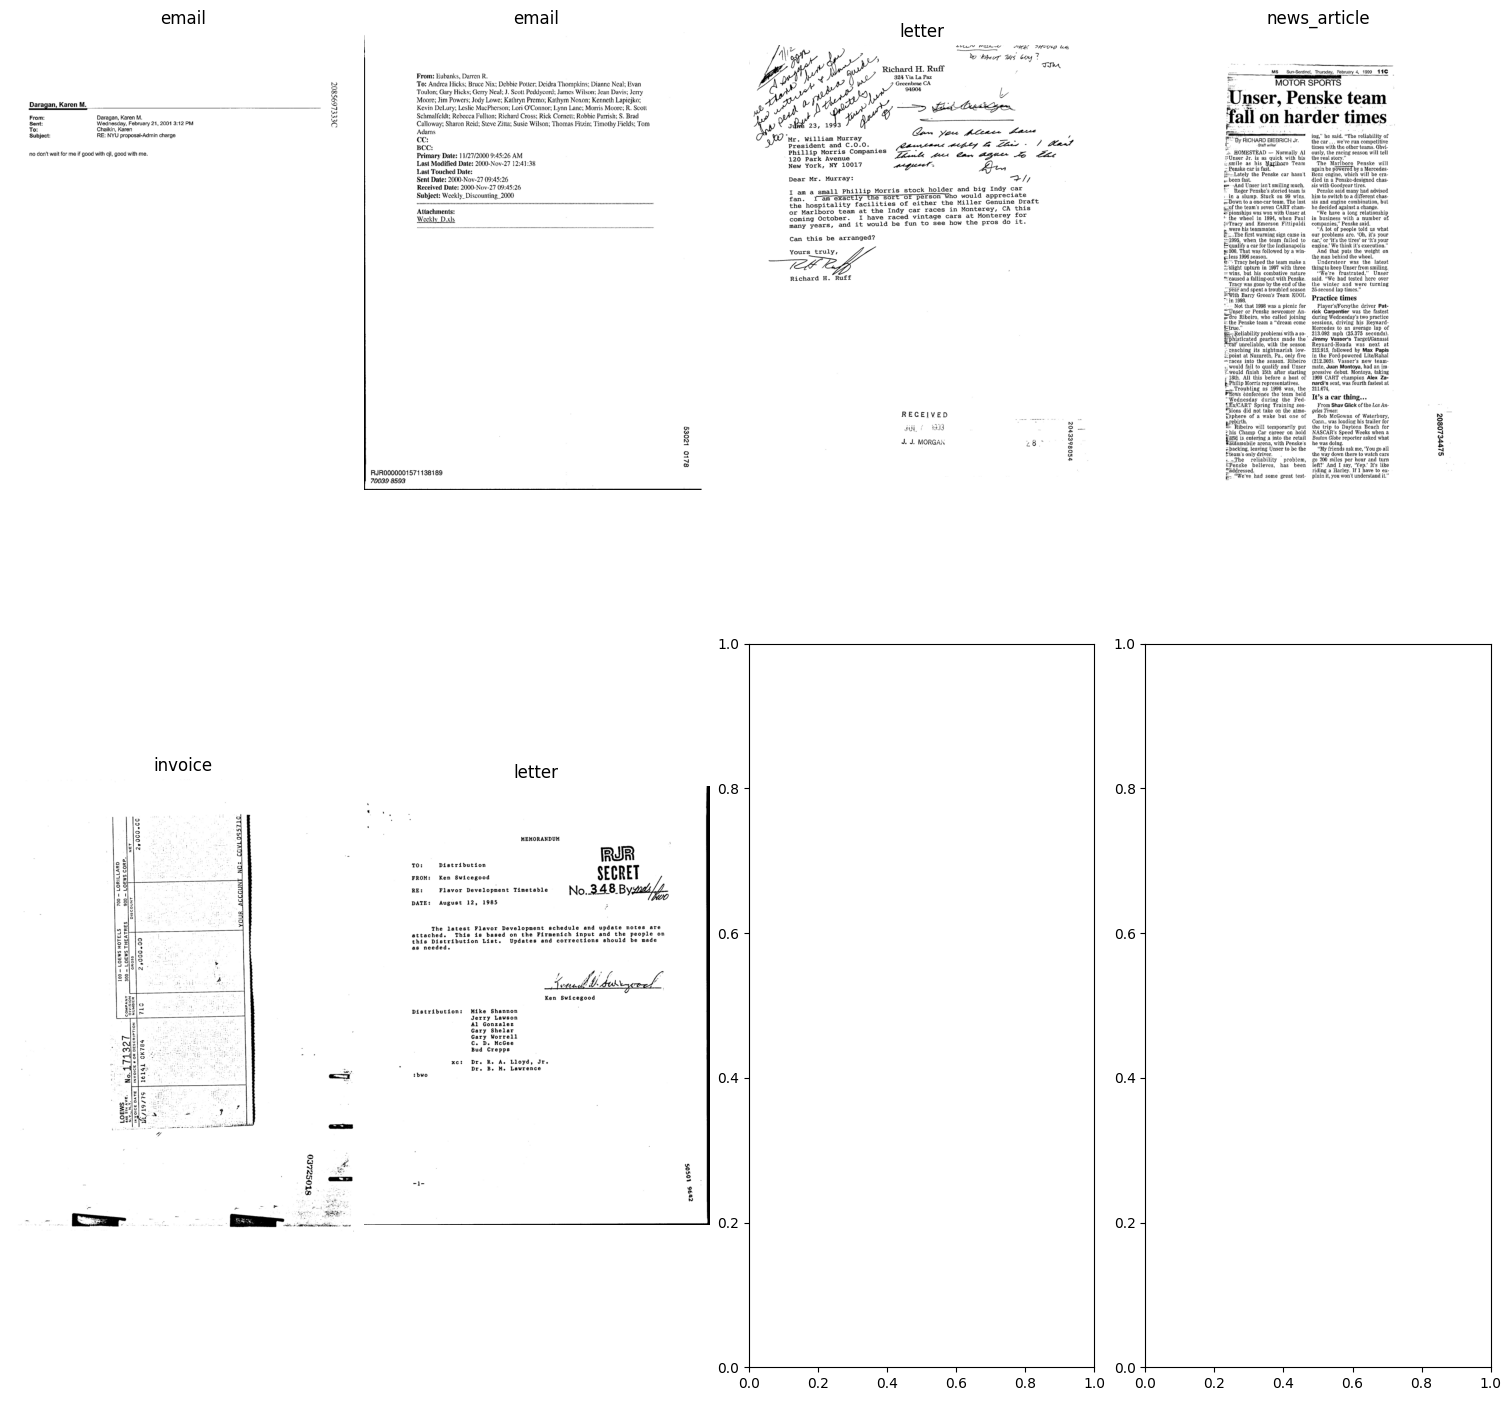

In [185]:
show_tif_image(6)

### show_tif_image_and_pred

In [229]:
def show_tif_image_and_pred(num=1):
    path_images, labels = get_diff_random_images_and_labels(num)
    images = [Image.open(img).convert('RGB') for img in path_images]
    x_batch = torch.stack([transform_val(img) for img in images], dim=0)
    
    np_images = [np.array(Image.open(img).convert('RGB')) for img in path_images]    # Для отрисовки через plt.imshow()
    
    with torch.inference_mode():
        logits_tensor = model(x_batch)    # [batch, classes]
        probs = torch.softmax(logits_tensor, dim=1)
        pred_idxs = probs.argmax(dim=1)     # shape: [9] → tensor([1, 0, 3, ...])
        pred_classes = le.inverse_transform(pred_idxs)
        
        confidences = probs.max(dim=1).values    # Вероятность класса
    
    
    if num == 1:
        plt.figure(figsize=[5,5])
        plt.imshow(np_images[0])
        plt.axis('off')
        plt.title(path_images[0].split('/')[2])
    
    
    # Преобразовываем num в сетку -> получим массив [columns, rows], предполагается, что сетка будет всегда в 4 колонки, а остатки уйдут в строки
    grid_size = [num // 4 if num % 4 == 0 else (num // 4) + 1, 4]
    
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=[15, 15], layout="constrained")
    
    index = 0
    for y in range(grid_size[0]):
        for x in range(grid_size[1]):
            if index == num: break
            
            color = 'g' if pred_classes[index] == path_images[index].split('/')[2] else 'r'
            
            axes[y, x].set_title(f'Predicted: {pred_classes[index]}\n True: {path_images[index].split('/')[2]}\n Model confidence: {confidences[index]:.4f}', c=color)
            axes[y, x].axis('off')
            axes[y, x].imshow(np_images[index])
            
            index += 1
    

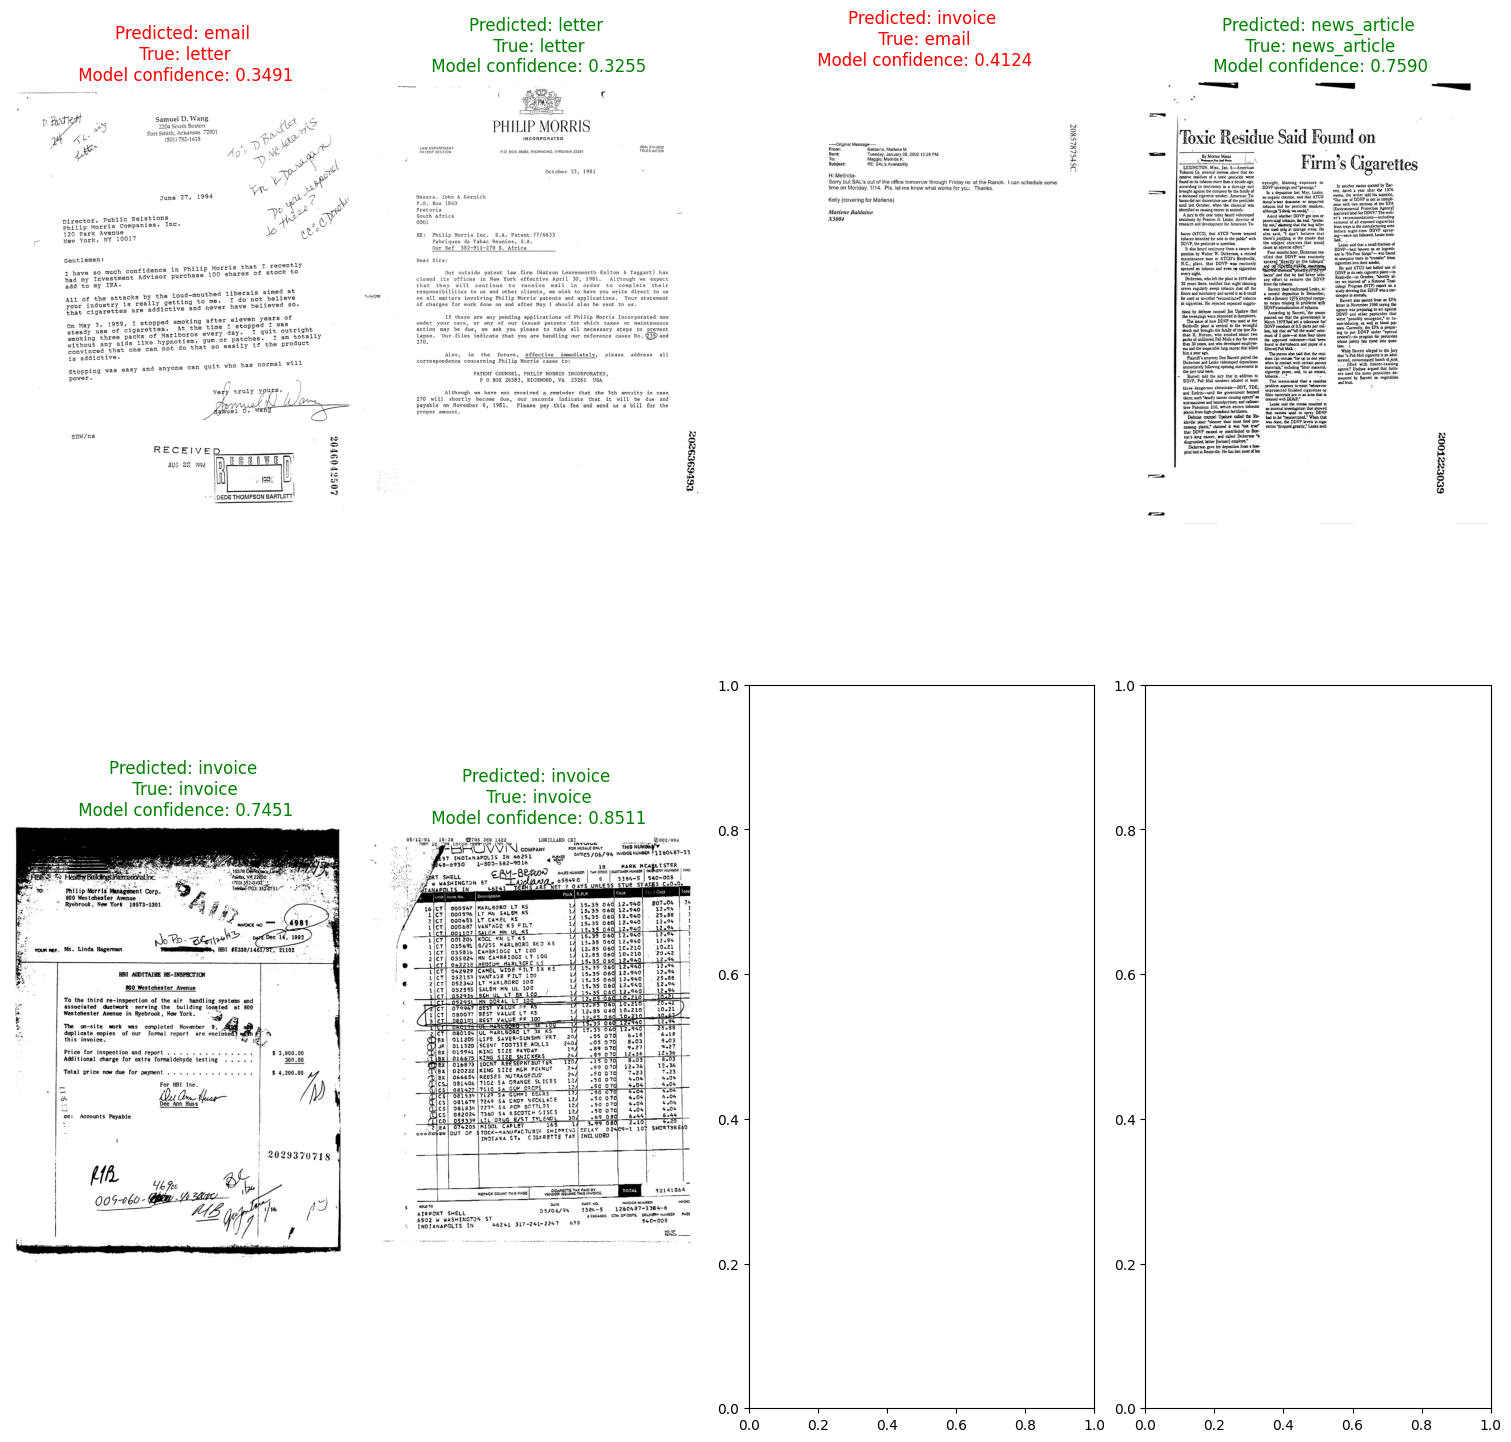

In [232]:
show_tif_image_and_pred(6)

In [ ]:
num = 9
taken_images = get_diff_random_images_and_labels(num)
images = [Image.open(img).convert('RGB') for img in taken_images[0]]
transformed = [transform_val(img) for img in images]

x_batch = torch.stack(transformed, dim=0)


with torch.inference_mode():
        logits_tensor = model(x_batch)    # [batch, classes]
        probs = torch.softmax(logits_tensor, dim=1)
        pred_idxs = probs.argmax(dim=1)     # shape: [9] → tensor([1, 0, 3, ...])
        # print(pred_idxs.shape)
        pred_classes = le.inverse_transform(pred_idxs)
        
        confidences = probs.max(dim=1).values
        
pred_classes, taken_images[1]


(array(['letter', 'news_article', 'news_article', 'invoice', 'invoice',
        'letter', 'letter', 'invoice', 'news_article'], dtype=object),
 array(['letter', 'letter', 'letter', 'email', 'news_article', 'invoice',
        'letter', 'email', 'news_article'], dtype='<U12'))

In [ ]:
pred_classes, taken_images[1]

In [ ]:
plt.figure(figsize=[5,5])
plt.imshow(img_np_arrays[0])
plt.axis('off')
plt.title(taken_images[0].split('/')[2])

### show_tif_image_by_path

In [219]:
def show_tif_image_by_path(path):
    # path - data/test/class_name/object_name.tif
    img_np = np.array(Image.open(path).convert('RGB'))
    label = path.split('/')[2]
    
    
    if num == 1:
        plt.figure(figsize=[5,5])
        plt.imshow(img_np)
        plt.axis('off')
        plt.title(taken_images[0].split('/')[2])
        
    return img_np, label

In [225]:
pred_classes, taken_images[1]

(array(['letter', 'news_article', 'news_article', 'invoice', 'invoice',
        'letter', 'letter', 'invoice', 'news_article'], dtype=object),
 ['letter',
  'letter',
  'letter',
  'email',
  'news_article',
  'invoice',
  'letter',
  'email',
  'news_article'])

In [224]:
pred_classes == taken_images[1]

array([ True, False, False, False, False, False,  True, False,  True])

In [110]:
num = 15
[4, num // 4 if num % 4 == 0 else (num // 4) + 1]

[4, 4]

data/test/letter/50044873.tif


Text(0.5, 1.0, 'letter')

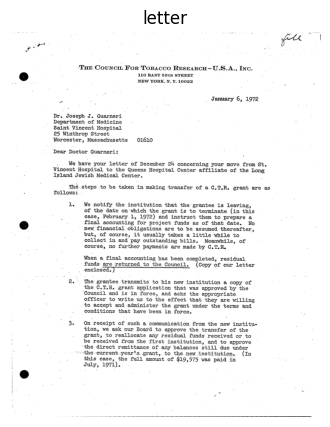

In [93]:
taken_images = take_diff_random_images(6)
print(taken_images[0])

img = Image.open(taken_images[0]).convert('RGB')
img_array = np.array(img)

plt.figure(figsize=[5,5])
plt.imshow(img_array)
plt.axis('off')
plt.title(taken_images[0].split('/')[2])

In [89]:
test_str = 'data/test/letter/81616345_81616346.tif'
test_str.split('/')[2]

'letter'

In [81]:
os.getcwd()

'/home/ilgiz/ml-engineering-portfolio/doc_image_classification'